In [1]:
import numpy as np
np.random.seed(12345)
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import gamma

In [2]:
# Number of simulations
N = 10000

# -------------------------------------------------------
# ---------------------- Constants ----------------------
# -------------------------------------------------------

HUB_H = 95.0                      # Hub height [m]
R = 45.0                          # Ejection radius [m]
RHO_AIR = 1.225                   # Density of air [kg/m^3]
RHO_ICE = 520.0                   # Density of ice (Snow ice blend) [kg/m^3]
C_D = 1.7                         # Drag coefficient (flat-shaped ice)
C_L = 1.0                         # Lift coefficient (flat-shaped ice)
MAX_WIND_SPEED = 28.0             # Maximum wind speed [m/s]
RATED_WIND_SPEED = 12.0           # Rated wind speed [m/s]
CUT_IN_WIND_SPEED = 3.0           # Cut-in wind speed [m/s]
CUT_OUT_WIND_SPEED = 28.0         # Cut-out wind speed [m/s]

MASS_MEAN = 0.67                  # Mean mass [kg]
AREA_MEAN = 0.0115                # Mean frontal area [m^2]
FIXED_WSPD = 15.0                 # Fixed wind speed [m/s]
#FIXED_WSPD = 8.075479                  # Fixed wind speed [m/s]

W_HUB = 7.6                       # Wind speed at hub height [m/s]
#FIXED_WSPD = W_HUB                # Fixed wind speed [m/s]
SHAPE_WIND = 2.0                  # Shape parameter for Weibull distribution

VON_K = 0.41                      # von Karman constant
z0 = 0.03                         # Roughness length (assumed)
g = 9.81                          # Gravity [m/s^2]

x_lim = 220                       # X-axis limit [m]
y_lim = 400                       # Y-axis limit [m]


In [3]:
def wind_profile(z, u_star):
    z_eff = max(z, z0)
    return (u_star / VON_K) * np.log(z_eff / z0)

def U_star(wspd):
    return (VON_K * wspd) / np.log(HUB_H / z0)

def initial_velocity(omega_rotor_speed, Rotor_Radius):
    return omega_rotor_speed * Rotor_Radius

def rotor_speed(wind_speed):
    MAX_OMEGA_ROTOR_SPEED = (7 * RATED_WIND_SPEED) / R
    
    if wind_speed < CUT_IN_WIND_SPEED:
        return 0.0
    elif wind_speed < RATED_WIND_SPEED:
        fraction = (wind_speed - CUT_IN_WIND_SPEED) / (RATED_WIND_SPEED - CUT_IN_WIND_SPEED)
        return fraction * MAX_OMEGA_ROTOR_SPEED
    elif wind_speed <= CUT_OUT_WIND_SPEED:
        return MAX_OMEGA_ROTOR_SPEED
    else:
        return 0.0
    
def eq_of_biswas(t, state, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star):
    x, y, z, vx, vy, vz = state

    U = wind_profile(z, u_star)

    V_rel_x = vx
    V_rel_y = vy - U
    V_rel_z = vz
    V_rel_H = np.sqrt(V_rel_x**2 + V_rel_y**2)
    V_rel = np.sqrt(V_rel_x**2 + V_rel_y**2 + V_rel_z**2)

    F_D = 0.5 * RHO_AIR * C_D * A_ref * (V_rel**2)
    F_L = 0.5 * RHO_AIR * C_L * A_ref * (V_rel**2)

    xsi_sin = V_rel_z / V_rel
    xsi_cos = V_rel_H / V_rel

    drag_x = -F_D * (V_rel_x / V_rel_H) * xsi_cos
    drag_y = -F_D * (V_rel_y / V_rel_H) * xsi_cos
    drag_z = -F_D * xsi_sin

    lift_x = F_L * (V_rel_x / V_rel_H) * xsi_sin
    lift_y = F_L * (V_rel_y / V_rel_H) * xsi_sin
    lift_z = F_L * xsi_cos

    ax = (lift_x + drag_x) / mass
    ay = (lift_y + drag_y) / mass
    az = -g + (lift_z + drag_z) / mass

    return np.array([vx, vy, vz, ax, ay, az])

def RK4(state0, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star, dt=0.01, t_max=100.0):
    t = 0.0
    state = np.array(state0)
    while t < t_max:
        if state[2] <= 0:  # If the ice piece has hit the ground, stop the simulation.
            break
        k1 = eq_of_biswas(t, state, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star)
        k2 = eq_of_biswas(t + dt/2.0, state + dt*k1/2.0, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star)
        k3 = eq_of_biswas(t + dt/2.0, state + dt*k2/2.0, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star)
        k4 = eq_of_biswas(t + dt, state + dt*k3, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star)
        state = state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t += dt
    return state

def trajectory(omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star, V_t):
    angle_rad = np.deg2rad(angle)
    # V_t = omega_rotor_speed * Rotor_Radius
    
    x0 = -Rotor_Radius * np.cos(angle_rad)
    y0 = 0.0
    z0 = Hub_H + Rotor_Radius * np.sin(angle_rad)

    vx0 = V_t * np.sin(angle_rad)
    vy0 = 0.0
    vz0 = V_t * np.cos(angle_rad)

    state0 = [x0, y0, z0, vx0, vy0, vz0]
    final_state = RK4(state0, omega_rotor_speed, mass, angle, C_D, C_L, A_ref, Rotor_Radius, Hub_H, U, u_star)
    x_impact = final_state[0]
    y_impact = final_state[1]
    return x_impact, y_impact

# WIND SPEED

Wind speed 28 m/s: 100%|██████████| 10000/10000 [04:14<00:00, 39.34it/s]


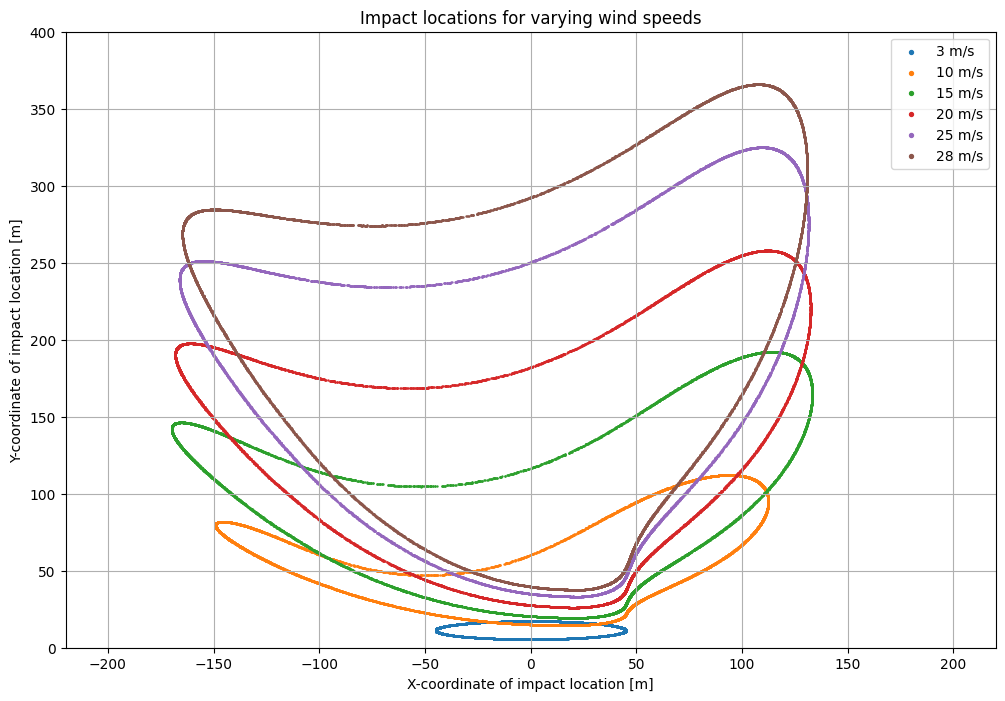

In [4]:
# List of wind speeds to test [m/s]
wind_speeds = [3, 10, 15, 20, 25, 28]
HUB_H = 95.0

plt.figure(figsize=(12, 8))
for wspd in wind_speeds:
    omega = rotor_speed(wspd)
    u_star = U_star(wspd)
    initial_velocity_t = initial_velocity(omega, R)
    x_impacts = np.zeros(N)
    y_impacts = np.zeros(N)
    random_angles = np.random.uniform(0, 360, N)
    
    for i in tqdm(range(N), desc=f'Wind speed {wspd} m/s'):
        angle = random_angles[i]
        x_imp, y_imp = trajectory(omega, MASS_MEAN, angle, C_D, C_L, AREA_MEAN, R, HUB_H, wspd, u_star, initial_velocity_t)
        x_impacts[i] = x_imp
        y_impacts[i] = y_imp
    plt.scatter(x_impacts, y_impacts, s=0.5, label=f'{wspd} m/s')

    # order = np.argsort(random_angles)
    # x_sorted = x_impacts[order]
    # y_sorted = y_impacts[order]
    # x_closed = np.concatenate([x_sorted, x_sorted[:1]])
    # y_closed = np.concatenate([y_sorted, y_sorted[:1]])
    
    # plt.plot(x_closed, y_closed)

plt.xlabel('X-coordinate of impact location [m]')
plt.ylabel('Y-coordinate of impact location [m]')
plt.xlim(-x_lim, x_lim)
plt.ylim(0, y_lim)
plt.title('Impact locations for varying wind speeds')
plt.legend(markerscale=4)
plt.grid(True)
plt.show()


# MATCHING AREA AND MASS

Mass 4.88 kg, Area 0.119 m^2: 100%|██████████| 10000/10000 [04:20<00:00, 38.35it/s]


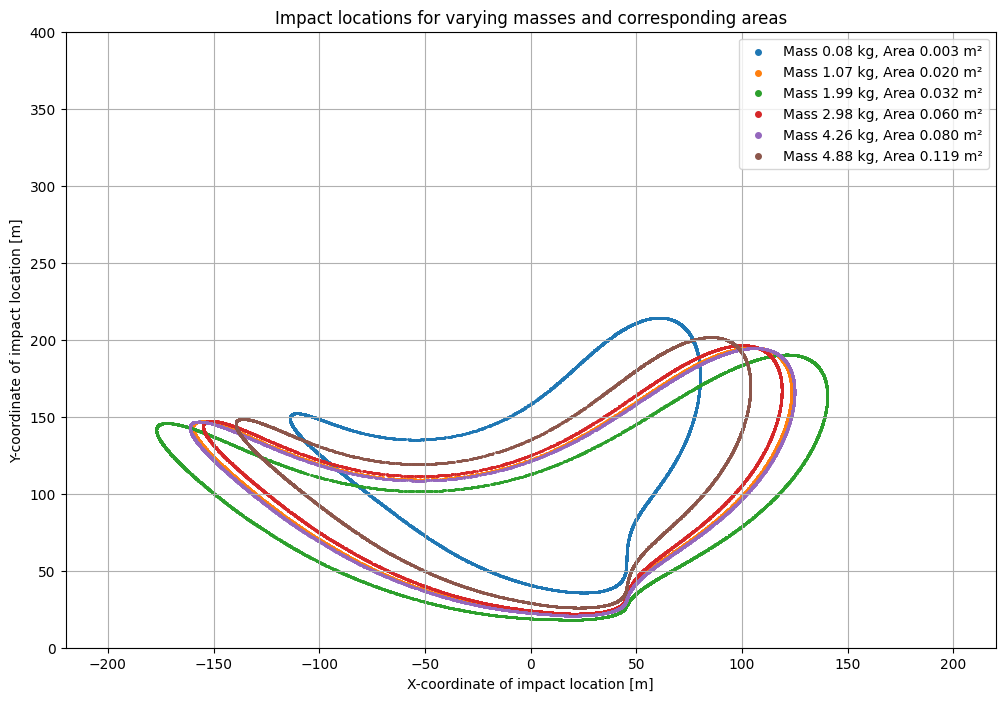

In [5]:
omega = rotor_speed(FIXED_WSPD)
u_star = U_star(FIXED_WSPD)
initial_velocity_t = initial_velocity(omega, R)

mass_list = [0.08, 1.07, 1.99, 2.98, 4.26, 4.88]
area_list = [0.0028803418803418804, 0.02048076923076923, 
             0.03173158323158323, 0.060188034188034194,
             0.08017708728053555, 0.1192962962962963]

plt.figure(figsize=(12, 8))

for mass, A_ref in zip(mass_list, area_list):
    x_impacts = np.zeros(N)
    y_impacts = np.zeros(N)
    random_angles = np.random.uniform(0, 360, N)

    for j in tqdm(range(N), desc=f'Mass {mass:.2f} kg, Area {A_ref:.3f} m^2'):
        angle = random_angles[j]
        x_imp, y_imp = trajectory(omega, mass, angle, C_D, C_L, A_ref, R, HUB_H, FIXED_WSPD, u_star, initial_velocity_t)
        x_impacts[j] = x_imp
        y_impacts[j] = y_imp

    plt.scatter(x_impacts, y_impacts, s=1, label=f'Mass {mass:.2f} kg, Area {A_ref:.3f} m²')

    # order = np.argsort(random_angles)
    # x_sorted = x_impacts[order]
    # y_sorted = y_impacts[order]
    # x_closed = np.concatenate([x_sorted, x_sorted[:1]])
    # y_closed = np.concatenate([y_sorted, y_sorted[:1]])
    
    # plt.plot(x_closed, y_closed)

plt.xlabel('X-coordinate of impact location [m]')
plt.ylabel('Y-coordinate of impact location [m]')
plt.xlim(-x_lim, x_lim)
plt.ylim(0, y_lim)
plt.title('Impact locations for varying masses and corresponding areas')
plt.legend(markerscale=4)
plt.grid(True)
plt.show()

# RADIAL POSITIONS

Radial position 60 m: 100%|██████████| 10000/10000 [04:06<00:00, 40.54it/s]


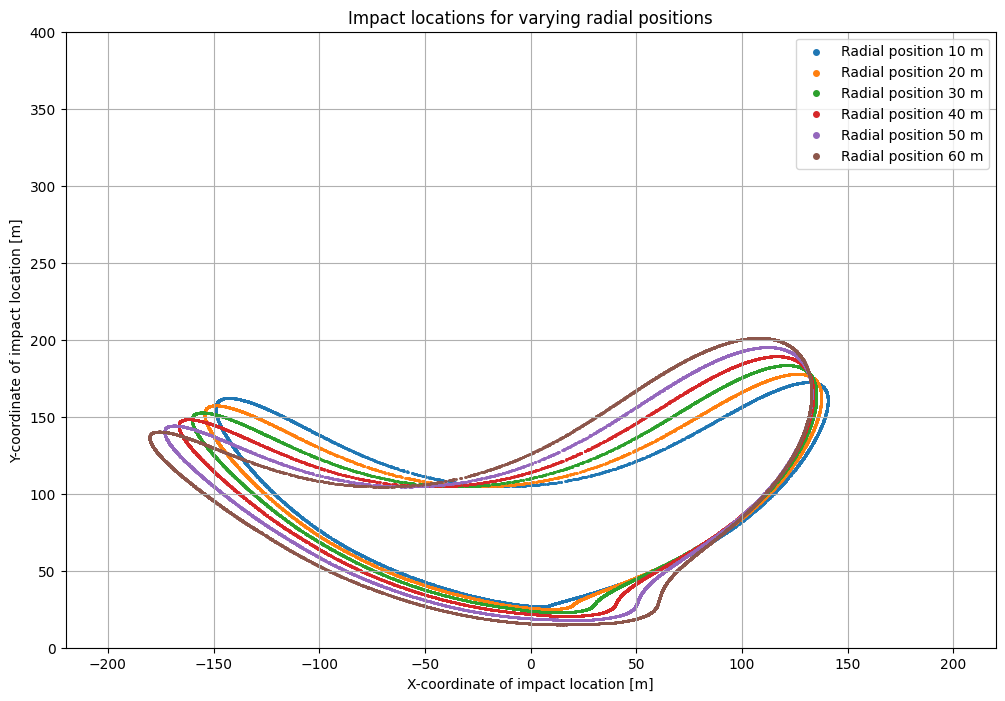

In [6]:
# Fixed wind speed for these simulations

# List of radiis to test [kg]
#radius_list = [20, 30, 40, 50, 60, 70, 80]
#radius_list = [15, 30, 45, 60, 75, 90]

radius_list = [10, 20, 30, 40, 50, 60]

plt.figure(figsize=(12, 8))
for radius in radius_list:
    x_impacts = np.zeros(N)
    y_impacts = np.zeros(N)
    random_angles = np.random.uniform(0, 360, N)
    omega_val = rotor_speed(FIXED_WSPD)
    for i in tqdm(range(N), desc=f'Radial position {radius} m'):
        angle = random_angles[i]
        x_imp, y_imp = trajectory(omega_val, MASS_MEAN, angle, C_D, C_L, AREA_MEAN, radius, HUB_H, FIXED_WSPD, u_star, initial_velocity_t)
        x_impacts[i] = x_imp
        y_impacts[i] = y_imp
    plt.scatter(x_impacts, y_impacts, s=1, label=f'Radial position {radius} m')

    # order = np.argsort(random_angles)
    # x_sorted = x_impacts[order]
    # y_sorted = y_impacts[order]
    # x_closed = np.concatenate([x_sorted, x_sorted[:1]])
    # y_closed = np.concatenate([y_sorted, y_sorted[:1]])
    
    # plt.plot(x_closed, y_closed)

plt.xlabel('X-coordinate of impact location [m]')
plt.ylabel('Y-coordinate of impact location [m]')
plt.xlim(-x_lim, x_lim)
plt.ylim(0, y_lim)
plt.title('Impact locations for varying radial positions')
plt.legend(markerscale=4)
plt.grid(True)
plt.show()

# HUB HEIGHT

Hub height 120 m: 100%|██████████| 10000/10000 [04:36<00:00, 36.17it/s]


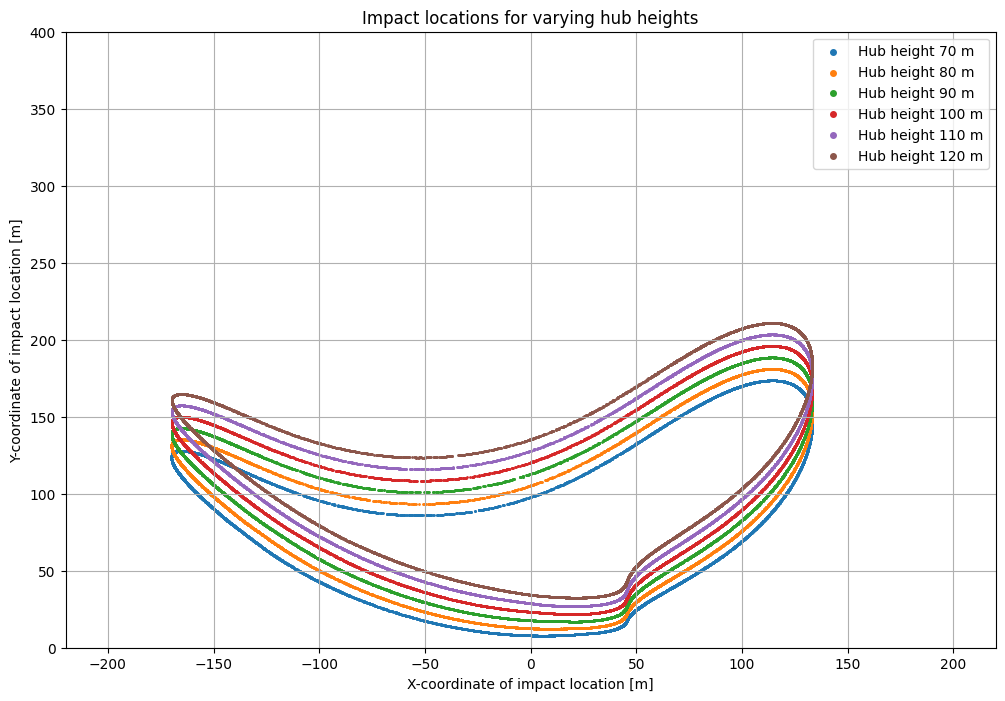

In [7]:
omega = rotor_speed(FIXED_WSPD)
hub_height_list = [70, 80, 90, 100, 110, 120]

plt.figure(figsize=(12, 8))
for hub in hub_height_list:
    x_impacts = np.zeros(N)
    y_impacts = np.zeros(N)
    random_angles = np.random.uniform(0, 360, N)
    for i in tqdm(range(N), desc=f'Hub height {hub} m'):
        angle = random_angles[i]
        x_imp, y_imp = trajectory(omega, MASS_MEAN, angle, C_D, C_L, AREA_MEAN, R, hub, FIXED_WSPD, u_star, initial_velocity_t)
        x_impacts[i] = x_imp
        y_impacts[i] = y_imp
    plt.scatter(x_impacts, y_impacts, s=1, label=f'Hub height {hub} m')

    # order = np.argsort(random_angles)
    # x_sorted = x_impacts[order]
    # y_sorted = y_impacts[order]
    # x_closed = np.concatenate([x_sorted, x_sorted[:1]])
    # y_closed = np.concatenate([y_sorted, y_sorted[:1]])
    
    # plt.plot(x_closed, y_closed)

plt.xlabel('X-coordinate of impact location [m]')
plt.ylabel('Y-coordinate of impact location [m]')
plt.xlim(-x_lim, x_lim)
plt.ylim(0, y_lim)
plt.title('Impact locations for varying hub heights')
plt.legend(markerscale=4)
plt.grid(True)
plt.show()

# INITIAL TANGENTIAL VELOCITY

V_t 102 m/s: 100%|██████████| 10000/10000 [04:20<00:00, 38.33it/s]


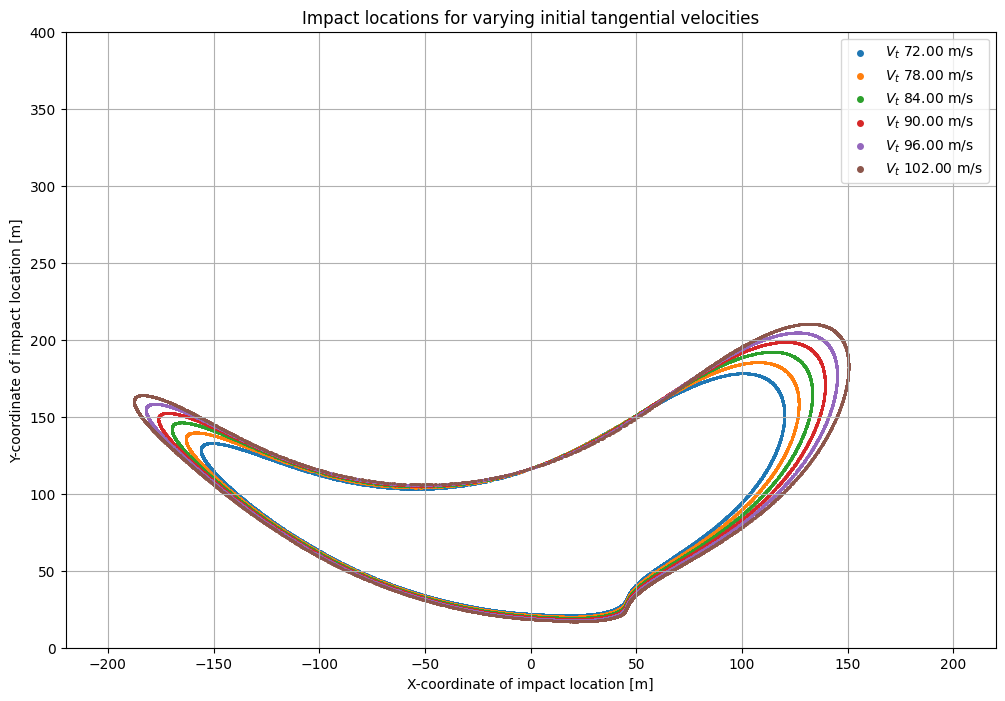

In [8]:
omega = rotor_speed(FIXED_WSPD)
initial_tangential_velocity = [72, 78, 84, 90, 96, 102]
# initial_tangential_velocity = [(6 * RATED_WIND_SPEED), (6.5 * RATED_WIND_SPEED), (7 * RATED_WIND_SPEED), (7.5 * RATED_WIND_SPEED), (8 * RATED_WIND_SPEED), (8.5 * RATED_WIND_SPEED)]
u_star = U_star(FIXED_WSPD)

plt.figure(figsize=(12, 8))
for vt in initial_tangential_velocity:
    x_impacts = np.zeros(N)
    y_impacts = np.zeros(N)
    random_angles = np.random.uniform(0, 360, N)
    for i in tqdm(range(N), desc=f'V_t {vt} m/s'):
        angle = random_angles[i]
        x_imp, y_imp = trajectory(omega, MASS_MEAN, angle, C_D, C_L, AREA_MEAN, R, HUB_H, FIXED_WSPD, u_star, vt)
        x_impacts[i] = x_imp
        y_impacts[i] = y_imp
    plt.scatter(x_impacts, y_impacts, s=1, label=f'$V_t$ {vt:.2f} m/s')

    # order = np.argsort(random_angles)
    # x_sorted = x_impacts[order]
    # y_sorted = y_impacts[order]
    # x_closed = np.concatenate([x_sorted, x_sorted[:1]])
    # y_closed = np.concatenate([y_sorted, y_sorted[:1]])
    
    # plt.plot(x_closed, y_closed)

plt.xlabel('X-coordinate of impact location [m]')
plt.ylabel('Y-coordinate of impact location [m]')
plt.xlim(-x_lim, x_lim)
plt.ylim(0, y_lim)
plt.title('Impact locations for varying initial tangential velocities')
plt.legend(markerscale=4)
plt.grid(True)
plt.show()

# EJECTION ANGLES

Ejection angle 315°: 100%|██████████| 10000/10000 [03:39<00:00, 45.52it/s]


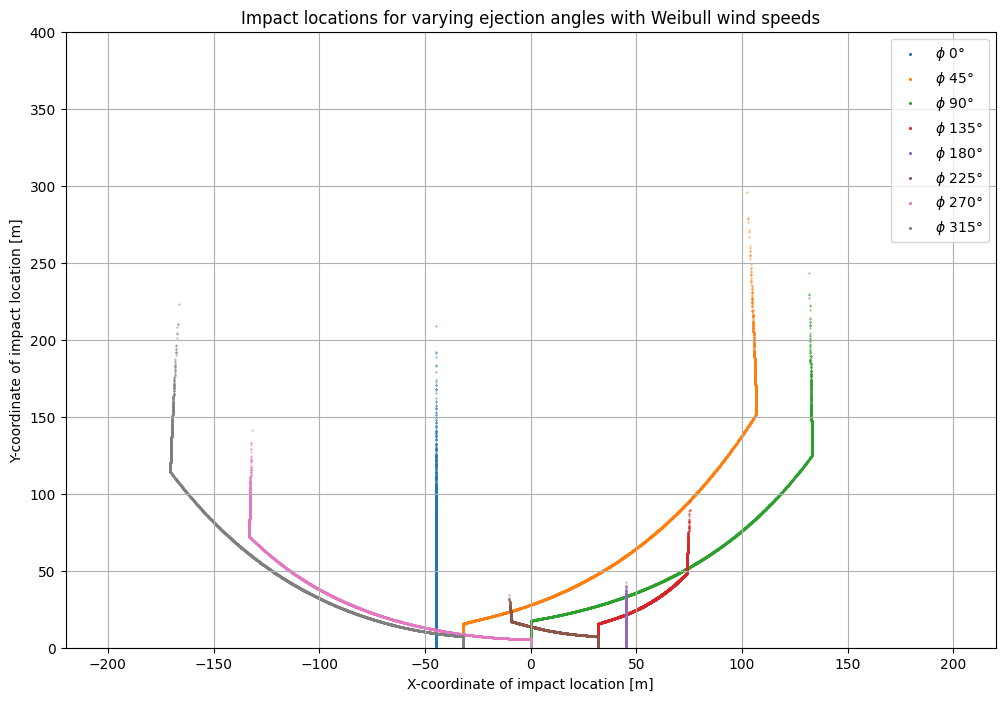

In [9]:
N = 10000

# ---------------------- Functions ----------------------
def weibull_scale(mean_wind_speed, shape):
    return mean_wind_speed / gamma(1.0 + 1.0/shape)

def wind_speed_distribution(scale, shape, size):
    return np.random.weibull(shape, size) * scale

def wind_profile(z, u_star):
    z_eff = max(z, z0)
    return (u_star / VON_K) * np.log(z_eff / z0)

def U_star(wspd):
    return (VON_K * wspd) / np.log(HUB_H / z0)

def rotor_speed(wind_speed):
    MAX_OMEGA_ROTOR_SPEED = (7 * RATED_WIND_SPEED) / R 
    
    if wind_speed < CUT_IN_WIND_SPEED:
        return 0.0
    elif wind_speed < RATED_WIND_SPEED:
        fraction = (wind_speed - CUT_IN_WIND_SPEED) / (RATED_WIND_SPEED - CUT_IN_WIND_SPEED)
        return fraction * MAX_OMEGA_ROTOR_SPEED
    elif wind_speed <= CUT_OUT_WIND_SPEED:
        return MAX_OMEGA_ROTOR_SPEED
    else:
        return 0.0

def eq_of_motion_fixed(t, state, mass, C_D, C_L, A_ref, U, u_star):
    x, y, z, vx, vy, vz = state

    U = wind_profile(z, u_star)

    V_rel_x = vx
    V_rel_y = vy - U
    V_rel_z = vz
    V_rel_H = np.sqrt(V_rel_x**2 + V_rel_y**2) + 1e-10  # Avoid division by zero
    V_rel = np.sqrt(V_rel_x**2 + V_rel_y**2 + V_rel_z**2) + 1e-10  # Avoid division by zero

    F_D = 0.5 * RHO_AIR * C_D * A_ref * (V_rel**2)
    F_L = 0.5 * RHO_AIR * C_L * A_ref * (V_rel**2)

    xsi_sin = V_rel_z / V_rel
    xsi_cos = V_rel_H / V_rel

    drag_x = -F_D * (V_rel_x / V_rel_H) * xsi_cos
    drag_y = -F_D * (V_rel_y / V_rel_H) * xsi_cos
    drag_z = -F_D * xsi_sin

    lift_x = F_L * (V_rel_x / V_rel_H) * xsi_sin
    lift_y = F_L * (V_rel_y / V_rel_H) * xsi_sin
    lift_z = F_L * xsi_cos

    ax = (lift_x + drag_x) / mass
    ay = (lift_y + drag_y) / mass
    az = -g + (lift_z + drag_z) / mass

    return np.array([vx, vy, vz, ax, ay, az])

def RK4_fixed(state0, mass, C_D, C_L, A_ref, U_fixed, u_star, dt=0.01, t_max=100.0):
    t = 0.0
    state = np.array(state0)
    while t < t_max:
        if state[2] <= 0:  # Stop if the ice piece has hit the ground.
            break
        k1 = eq_of_motion_fixed(t, state, mass, C_D, C_L, A_ref, U_fixed, u_star)
        k2 = eq_of_motion_fixed(t + dt/2.0, state + dt*k1/2.0, mass, C_D, C_L, A_ref, U_fixed, u_star)
        k3 = eq_of_motion_fixed(t + dt/2.0, state + dt*k2/2.0, mass, C_D, C_L, A_ref, U_fixed, u_star)
        k4 = eq_of_motion_fixed(t + dt, state + dt*k3, mass, C_D, C_L, A_ref, U_fixed, u_star)
        state = state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t += dt
    return state

def trajectory_fixed_U(omega_rotor_speed, mass, angle, A_ref, U_fixed, u_star):
    angle_rad = np.deg2rad(angle)
    V_t = omega_rotor_speed * R

    x0 = -R * np.cos(angle_rad)
    y0 = 0.0
    z0 = HUB_H + R * np.sin(angle_rad)

    vx0 = V_t * np.sin(angle_rad)
    vy0 = 0.0
    vz0 = V_t * np.cos(angle_rad)

    state0 = [x0, y0, z0, vx0, vy0, vz0]
    final_state = RK4_fixed(state0, MASS_MEAN, C_D, C_L, AREA_MEAN, U_fixed, u_star)

    x_impact = final_state[0]
    y_impact = final_state[1]

    return x_impact, y_impact


fixed_angles = [0, 45, 90, 135, 180, 225, 270, 315]

#scale_wind = weibull_scale(W_HUB, SHAPE_WIND)
# scale_wind = weibull_scale(W_HUB, SHAPE_WIND)
# wind_samples = wind_speed_distribution(scale_wind, SHAPE_WIND, N)

wind_samples = wind_speed_distribution(W_HUB, SHAPE_WIND, N)

plt.figure(figsize=(12, 8))

for angle in fixed_angles:
    x_impacts = np.zeros(N)
    y_impacts = np.zeros(N)
    
    for i in tqdm(range(N), desc=f"Ejection angle {angle}°"):
        U_sample = wind_samples[i]
        u_star_func = U_star(U_sample)
        omega = rotor_speed(U_sample)
        x_imp, y_imp = trajectory_fixed_U(omega, MASS_MEAN, angle, AREA_MEAN, U_sample, u_star_func)
        x_impacts[i] = x_imp
        y_impacts[i] = y_imp
        
    plt.scatter(x_impacts, y_impacts, s=0.1, label=f'$\phi$ {angle}°')
    #plt.plot(x_impacts, y_impacts)

    # order = np.argsort(random_angles)
    # x_sorted = x_impacts[order]
    # y_sorted = y_impacts[order]
    # x_closed = np.concatenate([x_sorted, x_sorted[:1]])
    # y_closed = np.concatenate([y_sorted, y_sorted[:1]])
    
    # plt.plot(x_closed, y_closed)

plt.xlabel('X-coordinate of impact location [m]')
plt.ylabel('Y-coordinate of impact location [m]')
plt.xlim(-x_lim, x_lim)
plt.ylim(0, y_lim)
plt.title('Impact locations for varying ejection angles with Weibull wind speeds')
plt.legend(markerscale=4)
plt.grid(True)
plt.show()

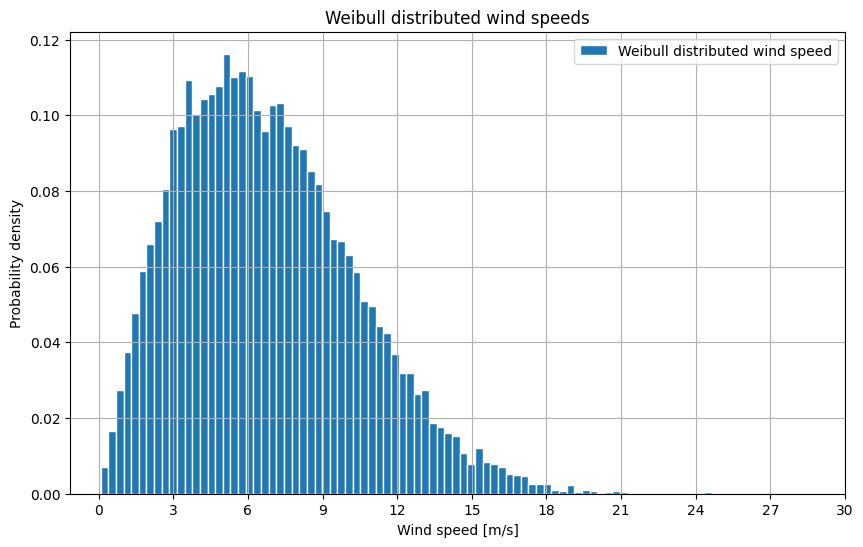

In [10]:
np.random.seed(12345)
def wind_speed_distribution(scale, shape, size):
    return np.random.weibull(shape, size) * scale

# scale_wind = weibull_scale(W_HUB, SHAPE_WIND)
# wind_speeds = wind_speed_distribution(scale_wind, SHAPE_WIND, N)

wind_speeds = wind_speed_distribution(W_HUB, SHAPE_WIND, N)

# x = np.linspace(0, np.max(wind_speeds), 200)
# k = SHAPE_WIND
# c = scale_wind

plt.figure(figsize=(10,6))
#weibull_fit = (k/c)*((x/c)**(k-1))*np.exp(-(x/c)**k) # Weibull formula
plt.hist(wind_speeds, bins=80, density=True, edgecolor='white', label='Weibull distributed wind speed')
#plt.plot(x, weibull_fit, linewidth=2, label='Weibull fitted')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Probability density')
plt.title('Weibull distributed wind speeds')
plt.xticks(np.arange(0, 31, 3))
plt.grid(True)
plt.legend()
plt.show()